# Shoplifting Detection from CCTV Videos
This notebook tackles the problem of detecting shoplifting activities from video footage. We will load a dataset of videos, preprocess them, and explore different deep learning models for classification.

Goal: Classify a video as either containing 'Shoplifting' or 'No Shoplifting'.

# 1. Setup and Imports
First, let's import all the necessary libraries. We'll need OpenCV for video processing, NumPy for numerical operations, TensorFlow/Keras for building our models, and matplotlib for visualization.

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import TimeDistributed, LSTM, GRU, ConvLSTM2D
from tensorflow.keras.applications import MobileNetV2

print("Libraries Imported!")

Libraries Imported!


# 2. Data Loading and Preprocessing
Our dataset is in two folders We need to:
- Read each video file.
- Extract a fixed number of frames from each video. Processing entire videos is computationally expensive, so we'll sample frames.
- Resize frames to a consistent dimension.
- Assign a label: 1 for Shoplifting, 0 for No Shoplifting.

- 70% of frames will be taken from the middle 50% of the video.

- 30% of frames will be taken from the beginning and end sections.

This ensures our model sees the context (start and end) but focuses its attention on the most critical part of the video where the action happens.

In [ ]:
# Configuration
IMG_SIZE = 128  # Resize frames to 128x128
MAX_FRAMES = 20
DATASET_PATH = "/kaggle/input/shoplifting-videos-dataset/Shop DataSet"

# Define folder paths
SHOPLIFTING_PATH = os.path.join(DATASET_PATH, "shop lifters")
NO_SHOPLIFTING_PATH = os.path.join(DATASET_PATH, "non shop lifters")

# Data loading function with Biased Sampling
def load_videos(folder_path, label):
    """
    Loads videos, extracts frames with a bias towards the middle, and assigns a label.
    """
    video_files = os.listdir(folder_path)
    sequences = []
    labels = []
    
    print(f"Processing folder: {folder_path}")
    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        cap = cv2.VideoCapture(video_path)
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Skip videos that are too short to sample from
        if total_frames < MAX_FRAMES:
            cap.release()
            continue

        frames = []
        
        # Biased Frame Sampling Logic
        # Define how many frames to take from the middle vs. edges
        n_frames_middle = int(MAX_FRAMES * 0.7)  # e.g., 14 frames
        n_frames_edges = MAX_FRAMES - n_frames_middle # e.g., 6 frames

        # Define the video sections
        middle_start_frame = int(total_frames * 0.25)
        middle_end_frame = int(total_frames * 0.75)

        # Generate indices for frames to extract
        middle_indices = np.linspace(middle_start_frame, middle_end_frame, n_frames_middle, dtype=int)
        edge_indices_start = np.linspace(0, middle_start_frame - 1, n_frames_edges // 2, dtype=int)
        edge_indices_end = np.linspace(middle_end_frame + 1, total_frames - 1, n_frames_edges - (n_frames_edges // 2), dtype=int)
        
        # Combine indices, ensure they are unique and sorted
        combined_indices = np.concatenate([edge_indices_start, middle_indices, edge_indices_end])
        unique_indices = np.unique(combined_indices)
        unique_indices.sort()

        # Extract the frames at the calculated indices
        for frame_idx in unique_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                frames.append(frame)
        
        cap.release()

        # Padding / Truncating to ensure fixed length
        # Ensure every sequence has exactly MAX_FRAMES
        if len(frames) > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif len(frames) < MAX_FRAMES and len(frames) > 0:
            # Pad with the last frame if we have too few
            padding = [frames[-1]] * (MAX_FRAMES - len(frames))
            frames.extend(padding)

        if len(frames) == MAX_FRAMES:
            sequences.append(np.array(frames))
            labels.append(label)
            
    return sequences, labels

# Load the data
print("Loading 'Shoplifting' videos...")
shoplifting_sequences, shoplifting_labels = load_videos(SHOPLIFTING_PATH, 1)
print(f"Loaded {len(shoplifting_sequences)} shoplifting videos.")

print("\nLoading 'No Shoplifting' videos...")
no_shoplifting_sequences, no_shoplifting_labels = load_videos(NO_SHOPLIFTING_PATH, 0)
print(f"Loaded {len(no_shoplifting_sequences)} 'no shoplifting' videos.")

# Combine and prepare the final dataset
X = np.array(shoplifting_sequences + no_shoplifting_sequences)
y = np.array(shoplifting_labels + no_shoplifting_labels)

# Normalize pixel values to be between 0 and 1
X = X / 255.0

print(f"\nFinal dataset shape (Videos, Frames, Height, Width, Channels): {X.shape}")
print(f"Final labels shape: {y.shape}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading 'Shoplifting' videos...
Processing folder: /kaggle/input/shoplifting-videos-dataset/Shop DataSet/shop lifters
Loaded 324 shoplifting videos.

Loading 'No Shoplifting' videos...
Processing folder: /kaggle/input/shoplifting-videos-dataset/Shop DataSet/non shop lifters
Loaded 531 'no shoplifting' videos.

Final dataset shape (Videos, Frames, Height, Width, Channels): (855, 20, 128, 128, 3)
Final labels shape: (855,)

Training data shape: (684, 20, 128, 128, 3)
Testing data shape: (171, 20, 128, 128, 3)


## Data Visualization

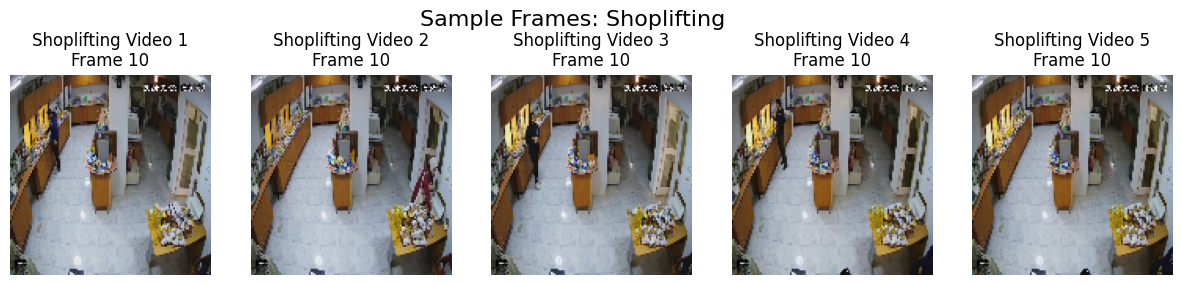

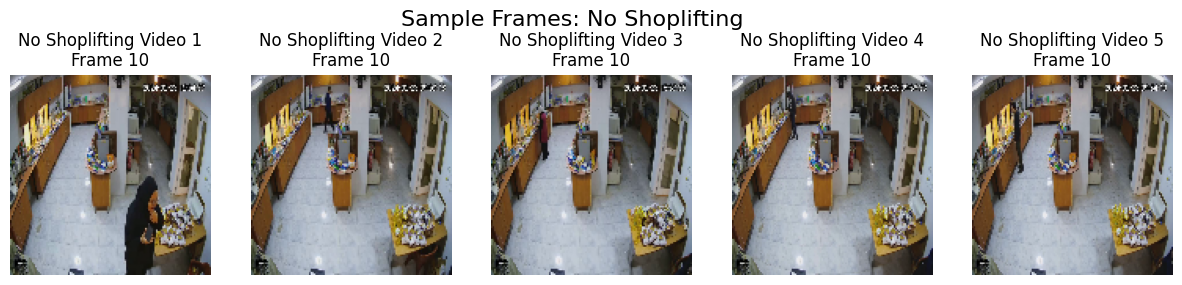

In [8]:
def plot_sample_frames(X, y, class_name):
    """Plots sample frames for a given class."""
    plt.figure(figsize=(15, 6))
    class_indices = np.where(y == (1 if class_name == "Shoplifting" else 0))[0]
    
    for i, idx in enumerate(class_indices[:5]): # Show first 5 videos of the class
        video = X[idx]
        # Show the 10th frame of the video
        frame = video[10] 
        plt.subplot(2, 5, i + 1)
        plt.imshow(frame)
        plt.title(f"{class_name} Video {i+1}\nFrame 10")
        plt.axis('off')

    plt.suptitle(f"Sample Frames: {class_name}", fontsize=16)
    plt.show()

# Visualize some training samples
plot_sample_frames(X_train, y_train, "Shoplifting")

plot_sample_frames(X_train, y_train, "No Shoplifting")

# 3. Model Suggestions
## Model 1: 3DCNN Architecture

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

input_shape = (MAX_FRAMES,IMG_SIZE, IMG_SIZE, 3)

conv3d_model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),

    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Conv3D(128, (3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

conv3d_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
conv3d_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 18, 126, 126,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 18, 63, 63, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 63, 63, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 61, 61, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 6, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    19,267,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,548,289 (74.57 MB)

 Trainable params: 19,547,841 (74.57 MB)

 Non-trainable params: 448 (1.75 KB)

### Training The 3D Conv Model

In [10]:
history_3d = conv3d_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=8,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])


Epoch 1/10


2025-08-08 09:54:37.350058: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,18,63,63]{4,3,2,1,0}, f32[8,64,16,61,61]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-08 09:54:37.860522: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.510586487s
Trying algorithm eng0{} for conv (f32[64,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,18,63,63]{4,3,2,1,0}, f32[8,64,16,61,61]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"a

86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 245ms/step - accuracy: 0.7085 - auc: 0.7283 - loss: 2.1182 - precision: 0.6400 - recall: 0.6668 - val_accuracy: 0.6199 - val_auc: 0.9903 - val_loss: 0.7108 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9024 - auc: 0.9630 - loss: 0.2475 - precision: 0.8709 - recall: 0.8821 - val_accuracy: 0.6199 - val_auc: 1.0000 - val_loss: 0.5819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9459 - auc: 0.9919 - loss: 0.1130 - precision: 0.9091 - recall: 0.9553 - val_accuracy: 0.7135 - val_auc: 1.0000 - val_loss: 0.4009 - val_precision: 1.0000 - val_recall: 0.2462
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9858 - auc: 0.9997 - loss: 0.0374 - precision: 0.9921 - recall: 0.9704 - val_accuracy: 0.9064 - val_auc: 1.0000 - val_loss: 0.2430 - val_precision: 1.0000 - val_recall: 0.7538
Epoch 5/10
86/86 ━━━━━━

### Visualizing results of 3D Conv Model

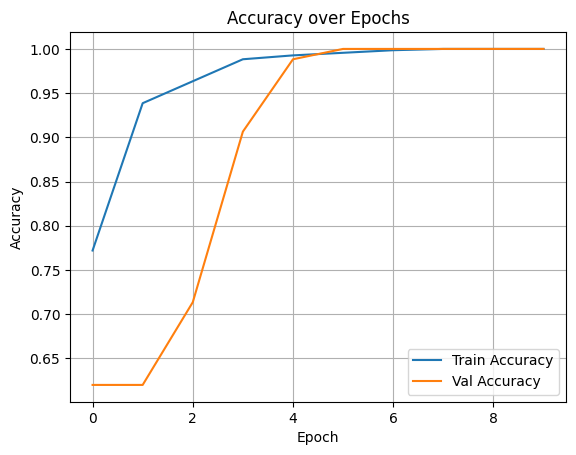

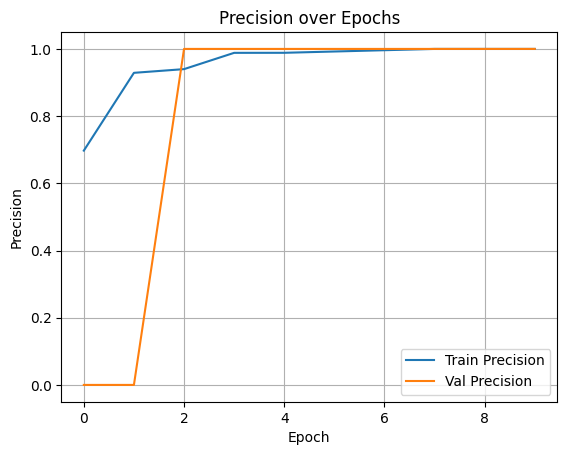

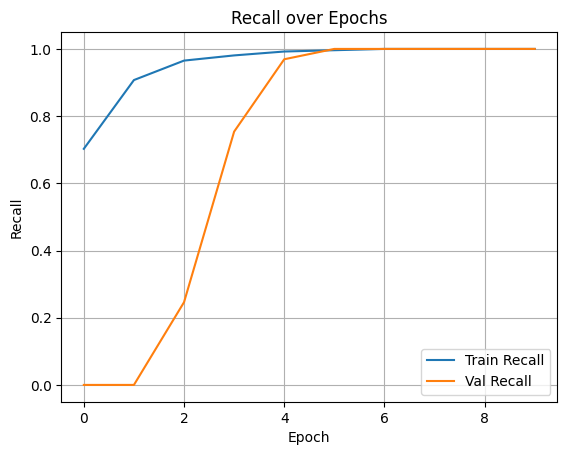

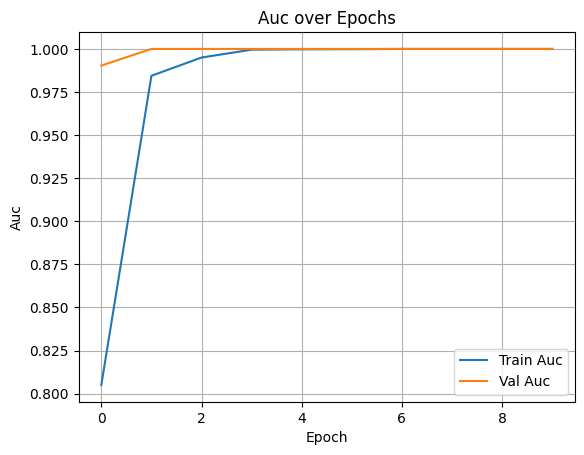

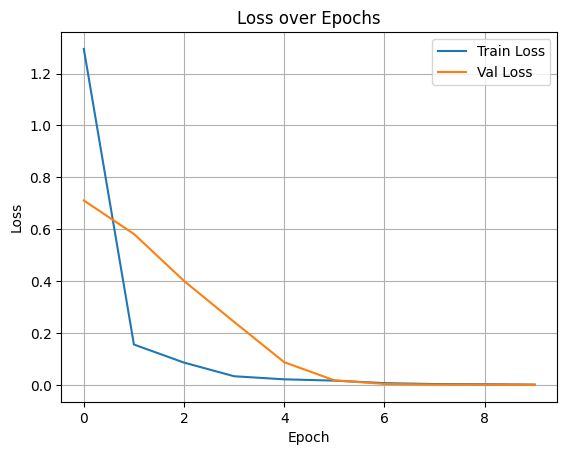

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']
    for metric in metrics:
        train_metric = history.history.get(metric)
        val_metric = history.history.get(f'val_{metric}')

        if train_metric is not None:
            plt.figure()
            plt.plot(train_metric, label=f'Train {metric.capitalize()}')
            if val_metric is not None:
                plt.plot(val_metric, label=f'Val {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.title(f'{metric.capitalize()} over Epochs')
            plt.legend()
            plt.grid(True)
            plt.show()
plot_training_history(history_3d)

### Model 2 : Pretrained CNN + LSTM

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


def build_cnn_plus_lstm_model():
    input_shape = (MAX_FRAMES,IMG_SIZE, IMG_SIZE, 3)
    input_layer= Input(shape=input_shape)

    cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in cnn_base.layers:
        layer.trainable=False
        
    cnn_out = TimeDistributed(cnn_base)(input_layer)
    cnn_out = TimeDistributed(GlobalAveragePooling2D())(cnn_out)
    cnn_out = TimeDistributed(BatchNormalization())(cnn_out)

    lstm_out = LSTM(128, return_sequences=False)(cnn_out)
    x = Dropout(0.5)(lstm_out)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)

    return model

In [13]:
lstm_model = build_cnn_plus_lstm_model()
lstm_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 1280)       │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,992,833 (11.42 MB)

 Trainable params: 732,289 (2.79 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

### Training the CNN + LSTM Model

In [14]:
from tensorflow.keras.metrics import Precision, Recall, AUC

lstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history_lstm = lstm_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=4,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 173s 342ms/step - accuracy: 0.7161 - auc_1: 0.6994 - loss: 0.5981 - precision_1: 0.6345 - recall_1: 0.4787 - val_accuracy: 0.9240 - val_auc_1: 0.9848 - val_loss: 0.2996 - val_precision_1: 0.8939 - val_recall_1: 0.9077
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8711 - auc_1: 0.9455 - loss: 0.3533 - precision_1: 0.8264 - recall_1: 0.7970 - val_accuracy: 0.9825 - val_auc_1: 0.9993 - val_loss: 0.1672 - val_precision_1: 1.0000 - val_recall_1: 0.9538
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.9366 - auc_1: 0.9787 - loss: 0.2384 - precision_1: 0.9362 - recall_1: 0.8936 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.1044 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.9561 - auc_1: 0.9904 - loss: 0.1694 - precision_1: 0.9486 - recall_1: 0.9312 - val_accuracy: 0.9942 - val_auc_1: 1.0000 - val_loss: 0.0707 - val_precision_1: 1

### Visualizing The Result Of the Model

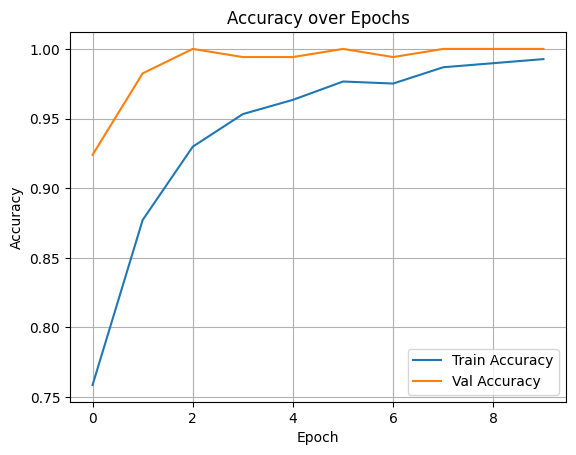

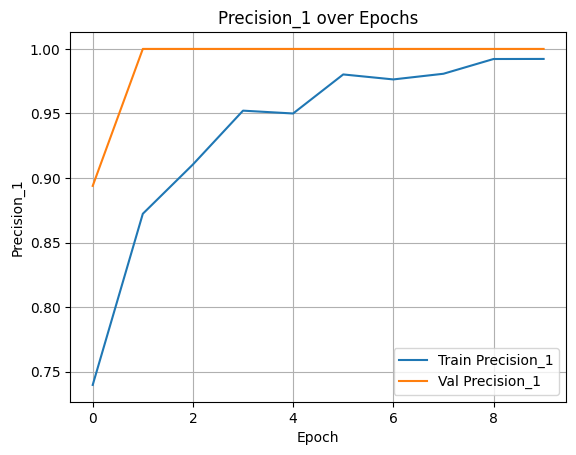

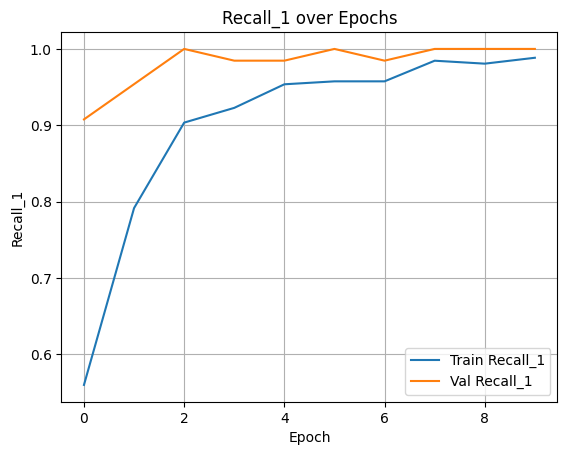

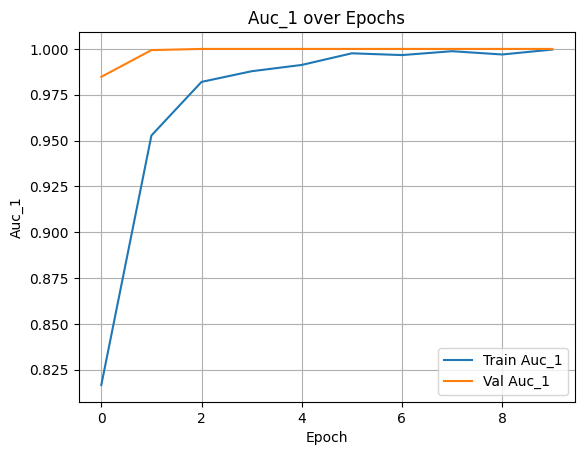

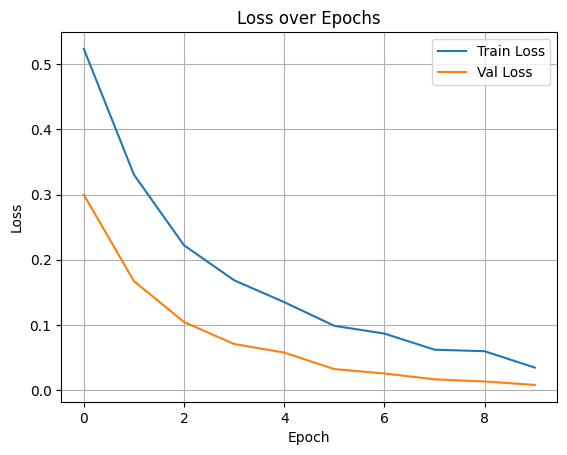

In [29]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['accuracy', 'precision_1', 'recall_1', 'auc_1', 'loss']
    for metric in metrics:
        train_metric = history.history.get(metric)
        val_metric = history.history.get(f'val_{metric}')

        if train_metric is not None:
            plt.figure()
            plt.plot(train_metric, label=f'Train {metric.capitalize()}')
            if val_metric is not None:
                plt.plot(val_metric, label=f'Val {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.title(f'{metric.capitalize()} over Epochs')
            plt.legend()
            plt.grid(True)
            plt.show()
plot_training_history(history_lstm)

### Model 3: Transformer

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dense, Dropout, GlobalAveragePooling2D,
    LayerNormalization, MultiHeadAttention, Add
)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    x = Add()([inputs, attention])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_cnn_plus_transformer():
    input_shape = (MAX_FRAMES, IMG_SIZE, IMG_SIZE, 3)
    input_layer = Input(shape=input_shape)

    cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    cnn_base.trainable = False

    x = TimeDistributed(cnn_base)(input_layer)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [17]:
transformer_model = build_cnn_plus_transformer()
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 20, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 20, 4, 4,  │  2,257,984 │ input_layer_5[0]… │
│ (TimeDistributed)   │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 20, 1280)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1280)  │  1,312,768 │ time_distributed… │
│ (MultiHeadAttentio… │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20, 1280)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 1280)  │          0 │ time_distributed… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 1280)  │      2,560 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 20, 128)   │    163,968 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20, 128)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 20, 1280)  │    165,120 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 1280)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1280)  │      2,560 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     81,984 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,987,009 (15.21 MB)

 Trainable params: 1,729,025 (6.60 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
from tensorflow.keras.metrics import Precision, Recall, AUC

transformer_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history_transformer = transformer_model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=4,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 204s 406ms/step - accuracy: 0.6777 - auc_2: 0.7236 - loss: 0.5980 - precision_2: 0.5834 - recall_2: 0.4745 - val_accuracy: 0.9240 - val_auc_2: 0.9851 - val_loss: 0.1869 - val_precision_2: 0.8611 - val_recall_2: 0.9538
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9127 - auc_2: 0.9671 - loss: 0.2075 - precision_2: 0.8622 - recall_2: 0.8936 - val_accuracy: 0.8889 - val_auc_2: 0.9951 - val_loss: 0.2535 - val_precision_2: 1.0000 - val_recall_2: 0.7077
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9285 - auc_2: 0.9903 - loss: 0.1320 - precision_2: 0.9176 - recall_2: 0.8809 - val_accuracy: 0.9298 - val_auc_2: 0.9994 - val_loss: 0.1336 - val_precision_2: 1.0000 - val_recall_2: 0.8154
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9848 - auc_2: 0.9984 - loss: 0.0446 - precision_2: 0.9905 - recall_2: 0.9692 - val_accuracy: 0.9766 - val_auc_2: 1.0000 - val_loss: 0.0405 - val_precision_2: 0.94

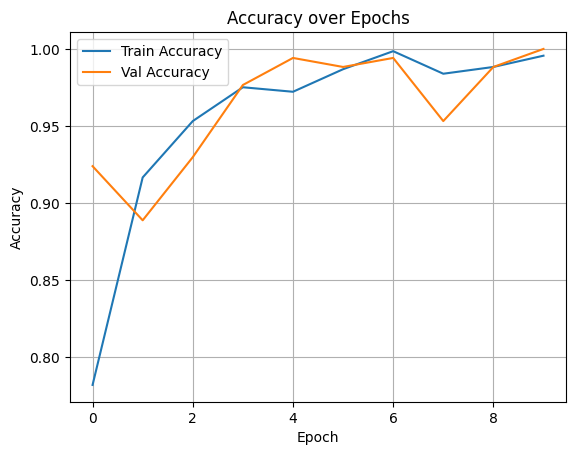

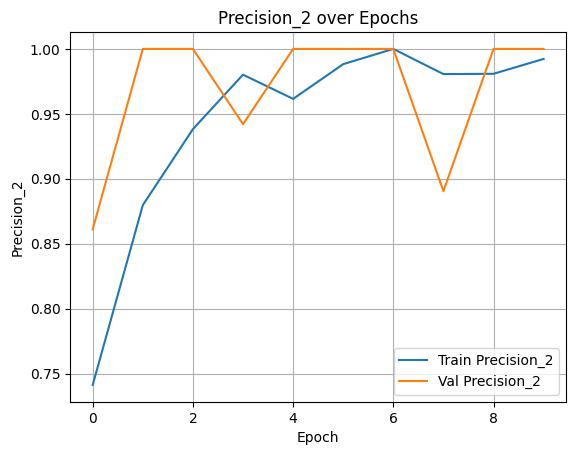

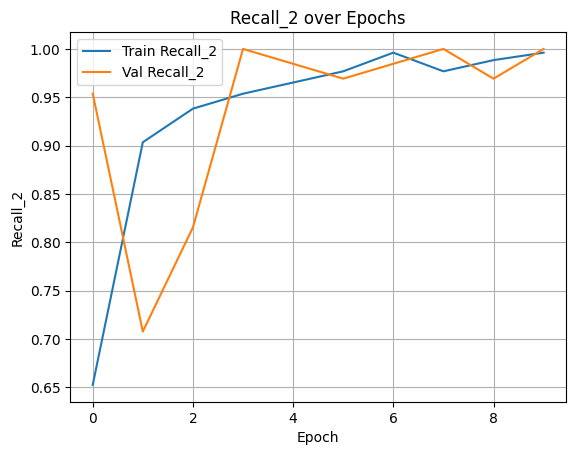

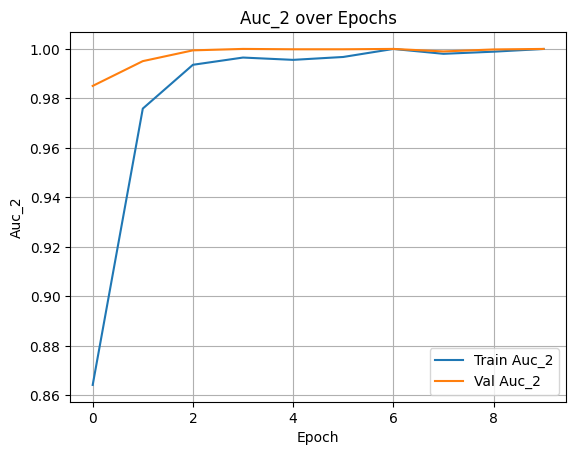

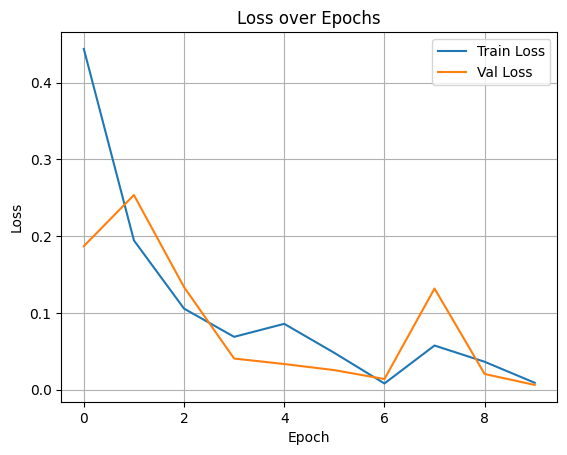

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['accuracy', 'precision_2', 'recall_2', 'auc_2', 'loss']
    for metric in metrics:
        train_metric = history.history.get(metric)
        val_metric = history.history.get(f'val_{metric}')

        if train_metric is not None:
            plt.figure()
            plt.plot(train_metric, label=f'Train {metric.capitalize()}')
            if val_metric is not None:
                plt.plot(val_metric, label=f'Val {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.title(f'{metric.capitalize()} over Epochs')
            plt.legend()
            plt.grid(True)
            plt.show()
plot_training_history(history_transformer)

# 4. Saving Models

In [20]:
conv3d_model.save('conv3d.h5')
lstm_model.save('lstm_model.h5')
transformer_model.save('transformer_model.h5')